In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler
import gseapy as gp

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
dic_map_m2h = {y:x for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
GS_FILE=DATA_PATH+'/gs_file/magma_10kb_1000.gs'
TRAIT_INFO_FILE=DATA_PATH+'/supp_table/trait_info.tsv'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_hep'

# Data set info
DS_LIST = ['facs', 'aizarani', 'halpern', 'richter', 'rao']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
# DIC_INFO['droplet'] = {'species': 'mmusculus', 'dname': 'TMS Droplet'}
DIC_INFO['aizarani'] = {'species': 'hsapiens', 'dname': 'Aizarani 2019'}
DIC_INFO['halpern'] = {'species': 'mmusculus', 'dname': 'Halpern Shenhav 2017'}
DIC_INFO['richter'] = {'species': 'mmusculus', 'dname': 'Richter Deligiannis 2020'}
DIC_INFO['rao'] = {'species': 'mmusculus', 'dname': 'Rao 2021'}

# Set score files
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000',
                  'facs.hm': DATA_PATH+'/score_file/score.tms_facs_with_cov.hep_metabolic',
                  'aizarani': DATA_PATH+'/score_file/score.liver_atlas.magma_10kb_1000',
                  'aizarani.hm': DATA_PATH+'/score_file/score.liver_atlas_with_cov.hep_metabolic',
                  'halpern': DATA_PATH+'/score_file/score.mouse_liver_halpern.magma_10kb_1000',
                  'halpern.hm': DATA_PATH+'/score_file/score.mouse_liver_halpern.hep_metabolic',  
                  'richter': DATA_PATH+'/score_file/score.richter_with_cov.magma_10kb_1000',
                  'richter.hm': DATA_PATH+'/score_file/score.richter_with_cov.hep_metabolic',  
                  'rao': DATA_PATH+'/score_file/score.rao_wang_with_cov.magma_10kb_1000',
                  'rao.hm': DATA_PATH+'/score_file/score.rao_wang_with_cov.hep_metabolic',  
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['facs'] = ['UKB_460K.biochemistry_AlanineAminotransferase',
                          'UKB_460K.biochemistry_AlkalinePhosphatase',
                          'UKB_460K.biochemistry_Cholesterol',
                          'UKB_460K.biochemistry_HDLcholesterol',
                          'UKB_460K.biochemistry_LDLdirect',
                          'UKB_460K.biochemistry_SHBG',
                          'UKB_460K.biochemistry_Testosterone_Male',
                          'UKB_460K.biochemistry_TotalBilirubin',
                          'UKB_460K.biochemistry_Triglycerides']
DIC_TRAIT_LIST['facs.hm'] = ['CV', 'PN', 'hep4n_richter', 'hep2n_richter', 
                             'case_96hPH_vs_prePH', 'case_prePH_vs_96hPH', 
                             'case_vs_ctrl_96hPH', 'ctrl_vs_case_96hPH', 'large_vs_small',
                             'Glycolysis', 'Bile acid production', 'Lipogenesis', 'Xenobiotic metabolism',
                             'Beta-oxidation', 'Cholesterol biosynthesis', 'Protein secretion', 'Gluconeogenesis', 
                             ]
DIC_TRAIT_LIST['aizarani'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['aizarani.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['halpern'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['halpern.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['richter'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['richter.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['rao'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['rao.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()

# Set trait info
DIC_HM_NAME = {'CV': 'CV',
               'PN': 'PN',
               'hep4n_richter': '4n',
               'hep2n_richter': '2n',
               'case_96hPH_vs_prePH': 'Polyploid (PH)',
               'case_prePH_vs_96hPH': 'Diploid (PH)',
               'case_vs_ctrl_96hPH': 'Polyploid (Cdk1)',
               'ctrl_vs_case_96hPH': 'Diploid (Cdk1)',
               'large_vs_small': 'Large',
               'Beta-oxidation': 'Beta-oxidation (PN)',
               'Cholesterol biosynthesis': 'Cholesterol biosynthesis (PN)', 
               'Glycolysis': 'Glycolysis (CV)', 
               'Protein secretion': 'Protein secretion (PN)',
               'Bile acid production': 'Bile acid production (CV)', 
               'Gluconeogenesis': 'Gluconeogenesis (PN)', 
               'Lipogenesis': 'Lipogenesis (CV)', 
               'Xenobiotic metabolism': 'Xenobiotic metabolism (CV)'}

DF_TRAIT_INFO = pd.read_csv(TRAIT_INFO_FILE, sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
for trait in DF_TRAIT_INFO.index[DF_TRAIT_INFO['Code'].isna()]:
    trait_short = trait.replace('PASS_','').replace('UKB_460K.','')
    trait_short = trait_short.replace('blood_','').replace('disease_','')
    DF_TRAIT_INFO.loc[trait, 'Code'] = trait_short

for trait in DIC_HM_NAME:
    DF_TRAIT_INFO.loc[trait, 'Code'] = DIC_HM_NAME[trait]
    

### Load data 

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
dic_data_raw['aizarani'] = dl.load_aizarani_raw_data(opt='raw')
dic_data_raw['halpern'] = dl.load_halpern_shenhav_raw_data(opt='raw')
dic_data_raw['richter'] = dl.load_richter_raw_data(opt='raw')
dic_data_raw['rao'] = dl.load_rao_raw_data(opt='raw')

dic_data_proc = {}
dic_data_proc['facs'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                                  'hep.facs_annot.h5ad')
dic_data_proc['aizarani'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/'
                                      'tms_proc/hep.aizarani.h5ad')
dic_data_proc['halpern'] = dl.load_halpern_shenhav_raw_data(opt='processed')
dic_data_proc['richter'] = dl.read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/'
                                        'tms_proc/hep.richter.h5ad')
dic_data_proc['rao'] = dl.read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/'
                                    'tms_proc/hep.rao.h5ad')

# Add percent.mt to facs data and filter out high mt cells 
temp_adata = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/tabula_muris_senis/'
                       'adata_genecode_counts_for_gatk_with_metadata.h5ad')
mt_list = [x for x in temp_adata.var_names if x.startswith('mt-')]
temp_adata.obs['percent.mt'] = temp_adata[:, mt_list].X.sum(axis=1) / temp_adata.X.sum(axis=1)

df_mt = pd.DataFrame(index=dic_data_proc['facs'].obs['cell'])
temp_df = temp_adata.obs.copy()
temp_df.index = temp_df['cell']
df_mt = df_mt.join(temp_df['percent.mt'])
dic_data_proc['facs'].obs['percent.mt'] = df_mt['percent.mt'].values
dic_data_proc['facs'] = dic_data_proc['facs'][dic_data_proc['facs'].obs['percent.mt']<0.3,:].copy()

Trying to set attribute `.obs` of view, copying.
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for score in DIC_SCORE_PATH:
    ds = score.replace('.hm','')
    dic_cell_list[score] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[score].index))

# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.mouse_liver_halpern.hep_metabolic/Lipogenesis.score.gz
# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.richter_with_cov.hep_metabolic/Lipogenesis.score.gz
# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.rao_wang_with_cov.hep_metabolic/Lipogenesis.score.gz


In [5]:
# # Compute correlation between n_gene and score 
# dic_data_raw['aizarani'].obs['n_genes'] = (dic_data_raw['aizarani'].X>0).sum(axis=1)
# df_plot = dic_data_raw['aizarani'].obs[['n_genes']]
# df_plot = df_plot.join(dic_score['aizarani'])
# df_plot = df_plot.loc[df_plot.isna().sum(axis=1)==0]
# for trait in DIC_TRAIT_LIST['aizarani']:
#     print('# %-30s    corr=%0.3f'%(trait, np.corrcoef(df_plot['n_genes'], df_plot['%s.norm_score'%trait])[0,1]))

In [6]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
# for score in ['aizarani', 'halpern', 'richter']:
    ds = score.split('.')[0]
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.full_score.gz'%trait)
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df = temp_df.loc[set(dic_data_proc[ds].obs_names) & set(temp_df.index)]
            dic_ctrl_score[score][trait] = temp_df.copy()
        else:
            print('# missing: %s'%file_path)
            continue
        dic_ctrl_score[score][trait] = dic_ctrl_score[score][trait].loc[dic_cell_list[score]].copy()

# Loading facs UKB_460K.biochemistry_AlanineAminotransferase
# Loading facs UKB_460K.biochemistry_AlkalinePhosphatase
# Loading facs UKB_460K.biochemistry_Cholesterol
# Loading facs UKB_460K.biochemistry_HDLcholesterol
# Loading facs UKB_460K.biochemistry_LDLdirect
# Loading facs UKB_460K.biochemistry_SHBG
# Loading facs UKB_460K.biochemistry_Testosterone_Male
# Loading facs UKB_460K.biochemistry_TotalBilirubin
# Loading facs UKB_460K.biochemistry_Triglycerides
# Loading facs.hm CV
# Loading facs.hm PN
# Loading facs.hm hep4n_richter
# Loading facs.hm hep2n_richter
# Loading facs.hm case_96hPH_vs_prePH
# Loading facs.hm case_prePH_vs_96hPH
# Loading facs.hm case_vs_ctrl_96hPH
# Loading facs.hm ctrl_vs_case_96hPH
# Loading facs.hm large_vs_small
# Loading facs.hm Glycolysis
# Loading facs.hm Bile acid production
# Loading facs.hm Lipogenesis
# Loading facs.hm Xenobiotic metabolism
# Loading facs.hm Beta-oxidation
# Loading facs.hm Cholesterol biosynthesis
# Loading facs.hm Protein secre

### Sanity checks 

facs


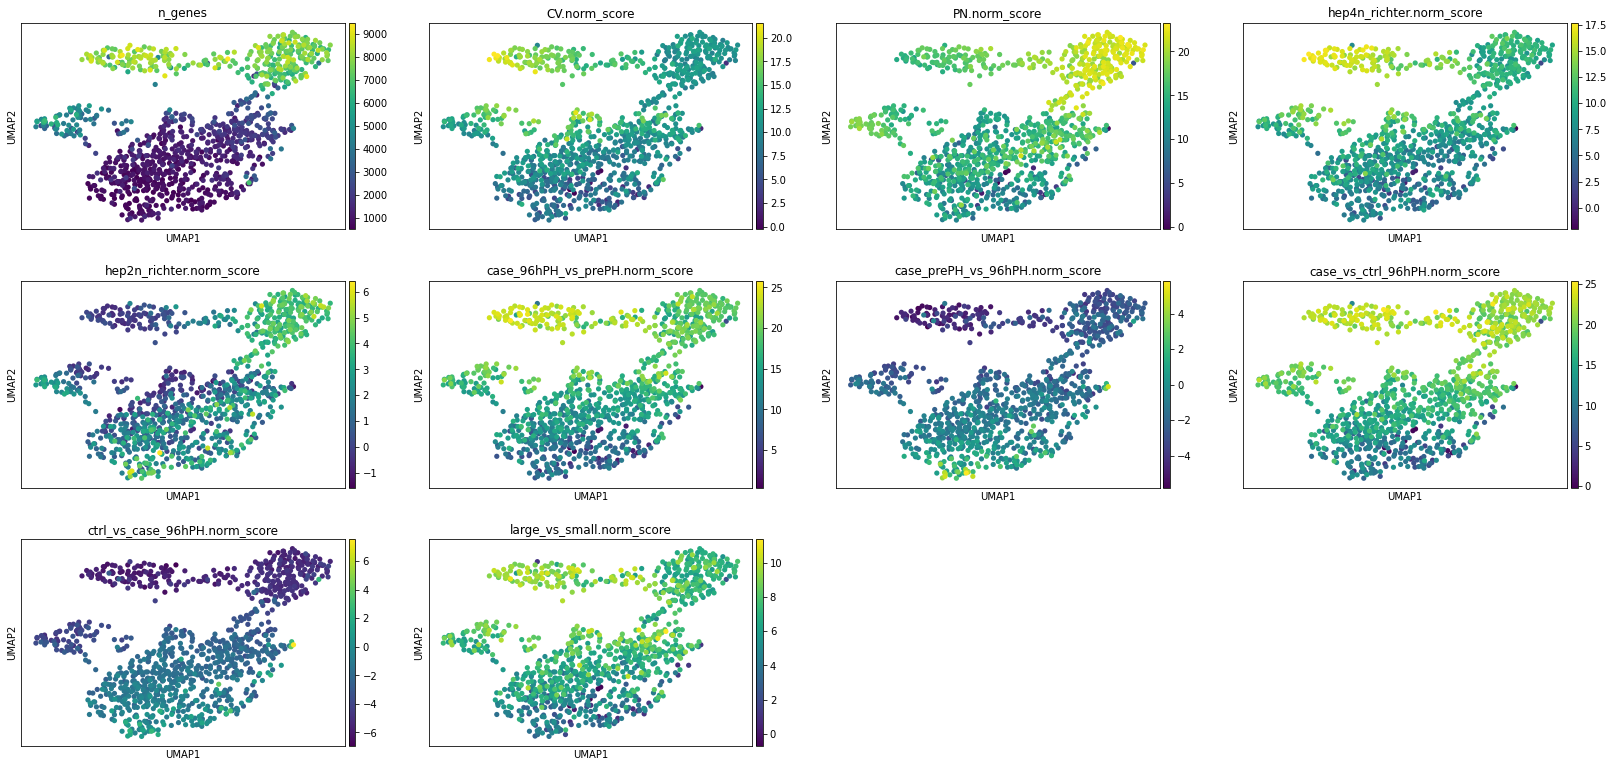

aizarani


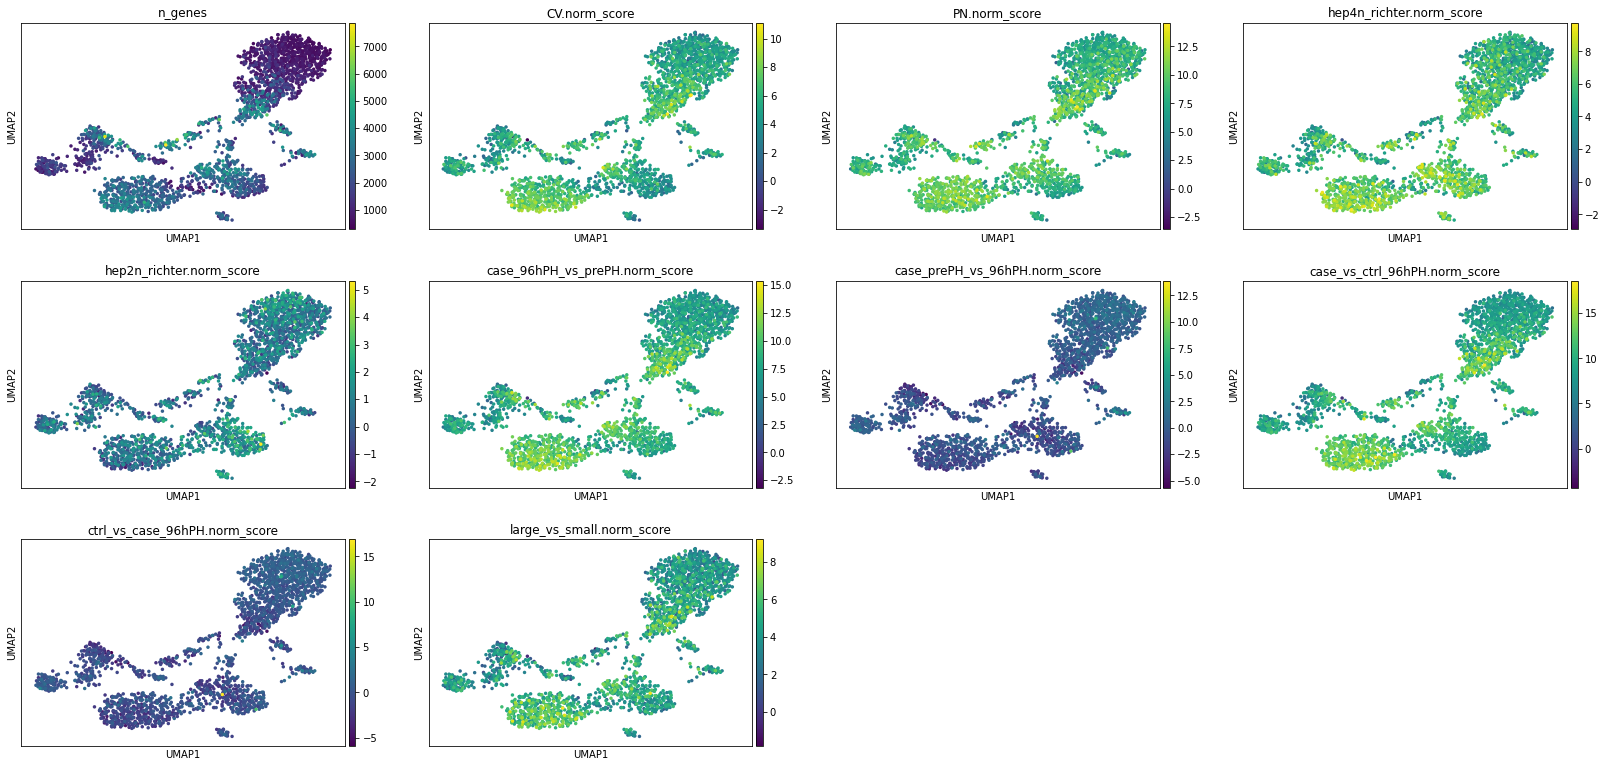

halpern


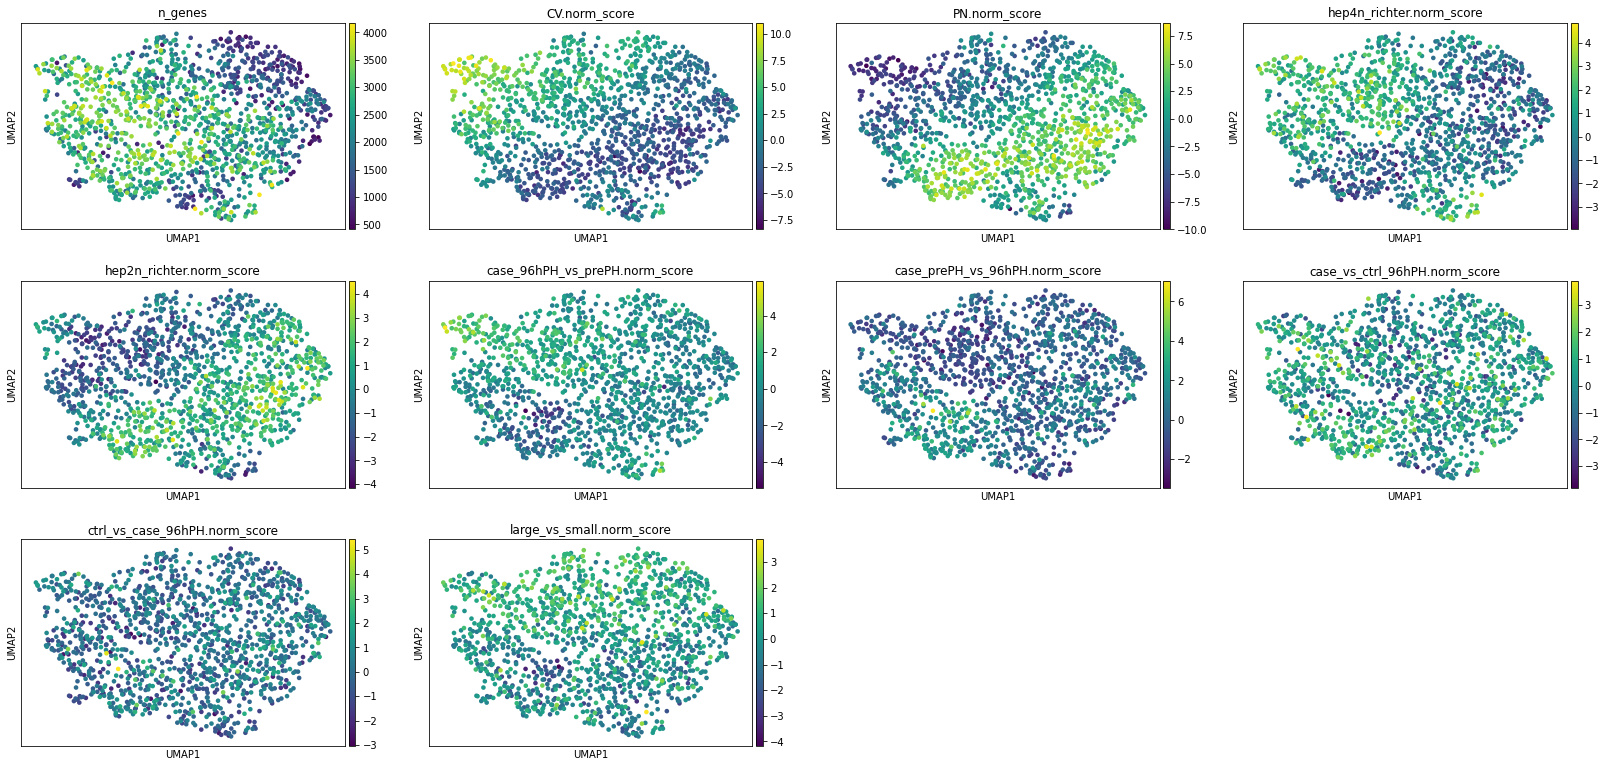

richter


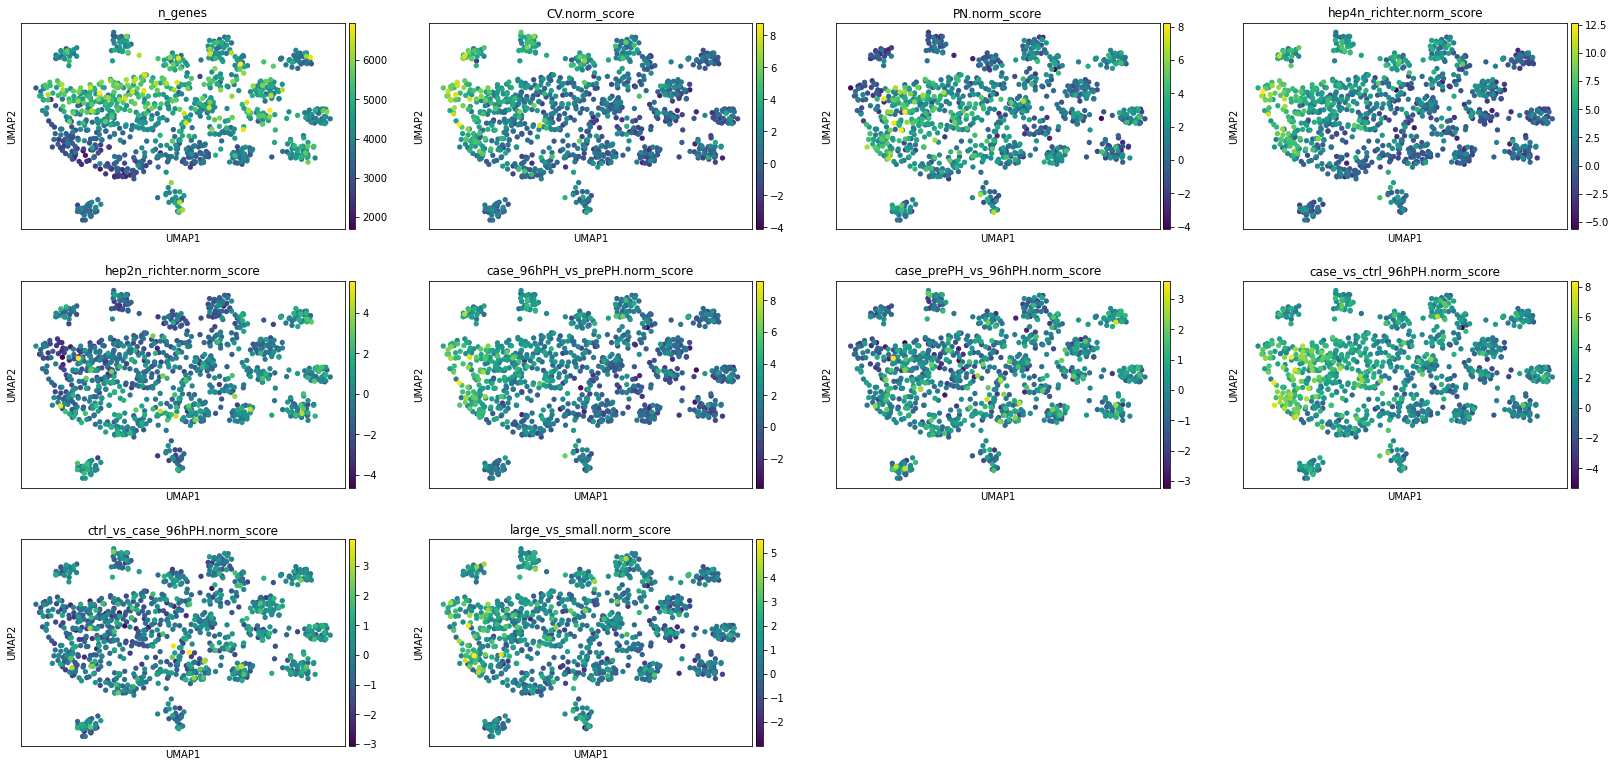

rao


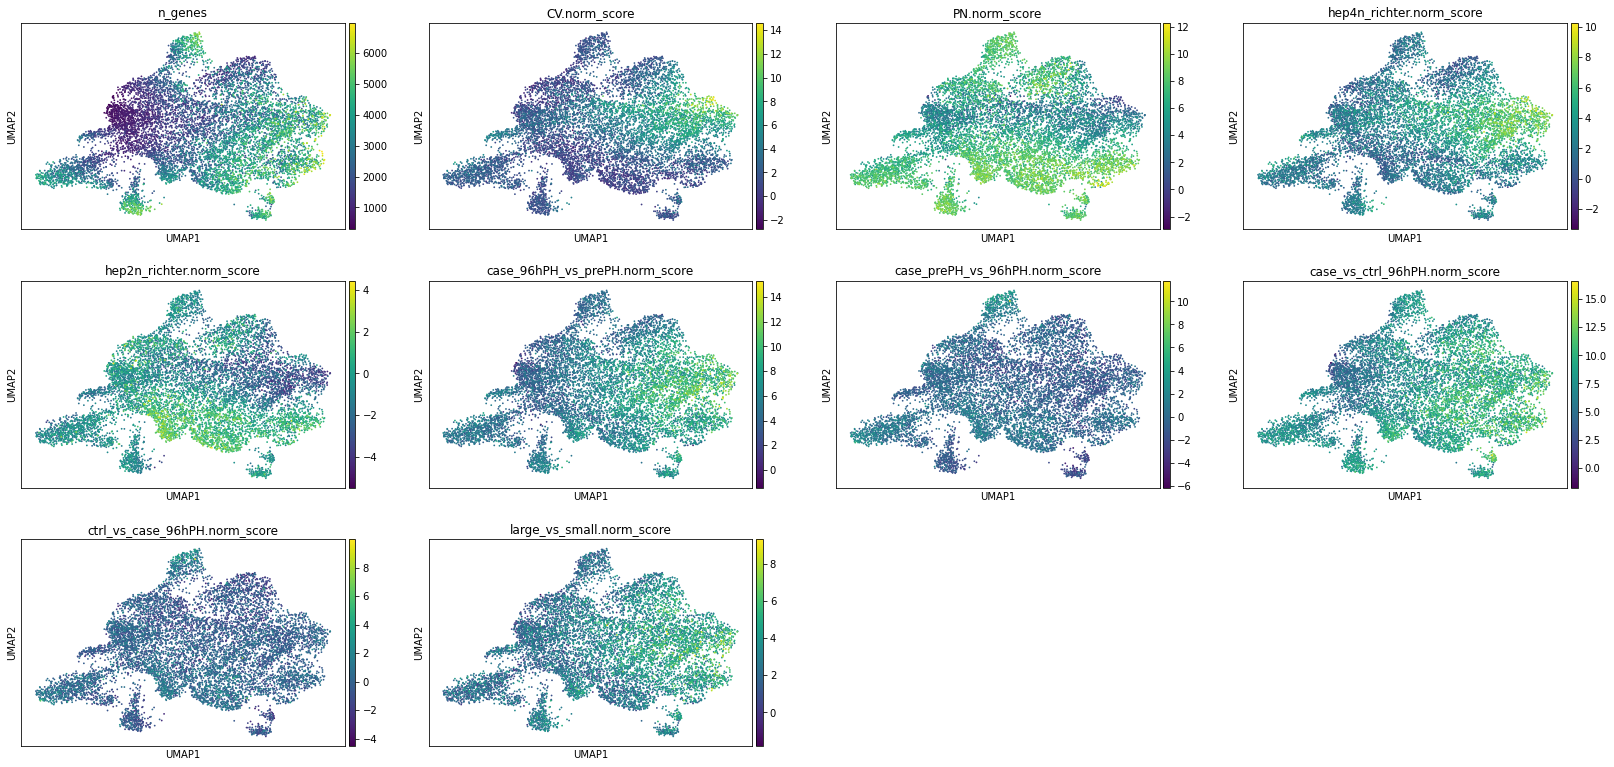

In [11]:
score_list = ['CV', 'PN', 'hep4n_richter', 'hep2n_richter', 
              'case_96hPH_vs_prePH', 'case_prePH_vs_96hPH', 'case_vs_ctrl_96hPH', 'ctrl_vs_case_96hPH',
              'large_vs_small']
for ds in DS_LIST:
    temp_data = dic_data_proc[ds].copy()
    temp_data.obs = temp_data.obs.join(dic_score['%s.hm'%ds][['%s.norm_score'%x for x in score_list]])
    print(ds)
    sc.pl.umap(temp_data, color=['n_genes']+['%s.norm_score'%x for x in score_list])

<AxesSubplot:xlabel='Ploidy', ylabel='case_96hPH_vs_prePH.norm_score'>

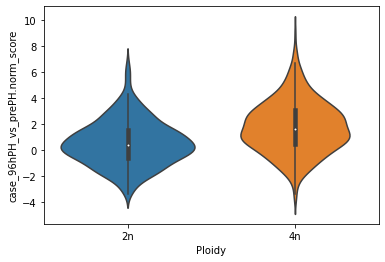

In [24]:
df_plot = dic_data_proc['richter'].obs.copy()
df_plot = df_plot.join(dic_score['richter.hm'][['case_96hPH_vs_prePH.norm_score']])
sns.violinplot(data=df_plot, x='Ploidy', y='case_96hPH_vs_prePH.norm_score')

### UMAP for all hepatocytes

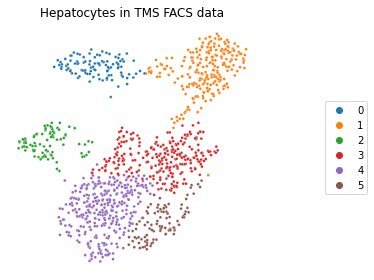

In [51]:
# Figure 
df_plot = pd.DataFrame(index=dic_data_proc['facs'].obs_names,
                       data={'UMAP1':dic_data_proc['facs'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc['facs'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(dic_data_proc['facs'].obs['leiden'])

plt.figure(figsize=[5.5,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='leiden', s=8)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('Hepatocytes in TMS FACS data')
plt.tight_layout()
plt.savefig(FIG_PATH+'/hep_tms_annot_umap.svg')
plt.savefig(FIG_PATH+'/hep_tms_annot_umap.png')
plt.show()

### Subpolulation of associated cells 

facs UKB_460K.biochemistry_AlanineAminotransferase


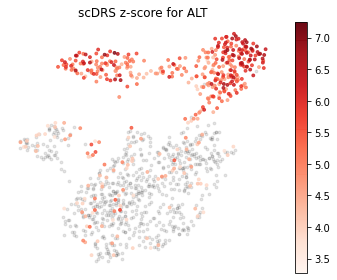

aizarani UKB_460K.biochemistry_AlanineAminotransferase


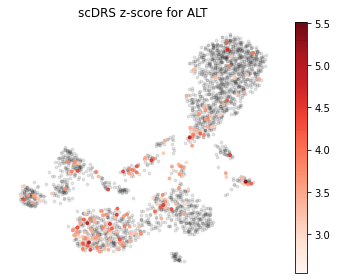

halpern UKB_460K.biochemistry_AlanineAminotransferase
richter UKB_460K.biochemistry_AlanineAminotransferase
rao UKB_460K.biochemistry_AlanineAminotransferase
facs UKB_460K.biochemistry_AlkalinePhosphatase


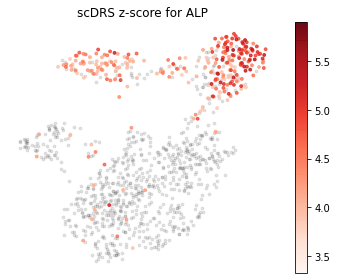

aizarani UKB_460K.biochemistry_AlkalinePhosphatase


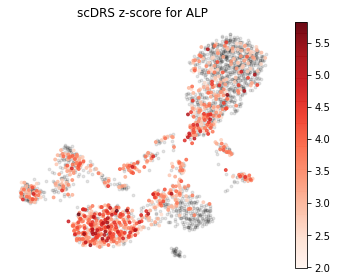

halpern UKB_460K.biochemistry_AlkalinePhosphatase
richter UKB_460K.biochemistry_AlkalinePhosphatase
rao UKB_460K.biochemistry_AlkalinePhosphatase
facs UKB_460K.biochemistry_Cholesterol


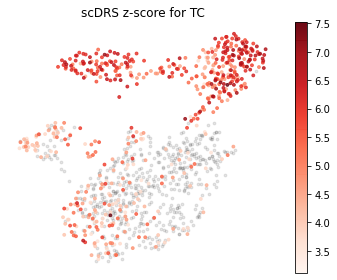

aizarani UKB_460K.biochemistry_Cholesterol


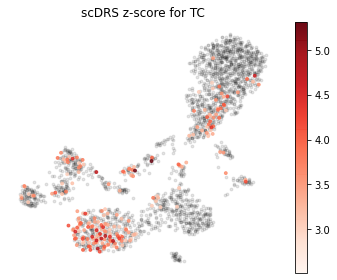

halpern UKB_460K.biochemistry_Cholesterol
richter UKB_460K.biochemistry_Cholesterol
rao UKB_460K.biochemistry_Cholesterol
facs UKB_460K.biochemistry_HDLcholesterol


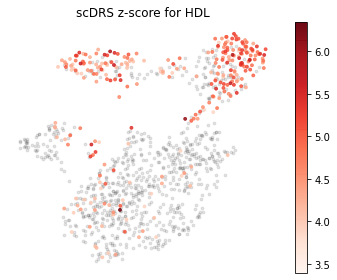

aizarani UKB_460K.biochemistry_HDLcholesterol


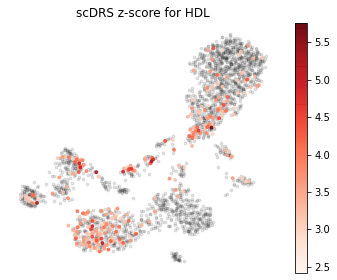

halpern UKB_460K.biochemistry_HDLcholesterol
richter UKB_460K.biochemistry_HDLcholesterol
rao UKB_460K.biochemistry_HDLcholesterol
facs UKB_460K.biochemistry_LDLdirect


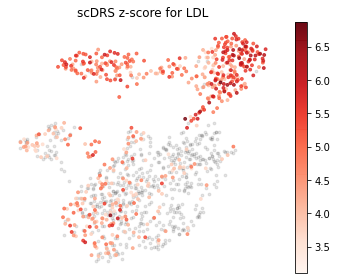

aizarani UKB_460K.biochemistry_LDLdirect


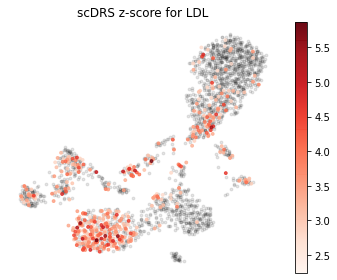

halpern UKB_460K.biochemistry_LDLdirect
richter UKB_460K.biochemistry_LDLdirect
rao UKB_460K.biochemistry_LDLdirect
facs UKB_460K.biochemistry_SHBG


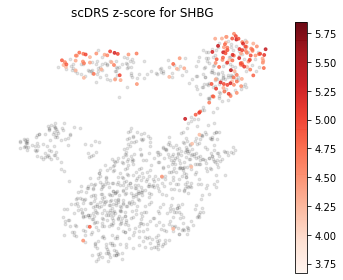

aizarani UKB_460K.biochemistry_SHBG


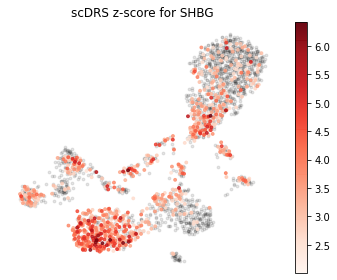

halpern UKB_460K.biochemistry_SHBG
richter UKB_460K.biochemistry_SHBG
rao UKB_460K.biochemistry_SHBG
facs UKB_460K.biochemistry_Testosterone_Male


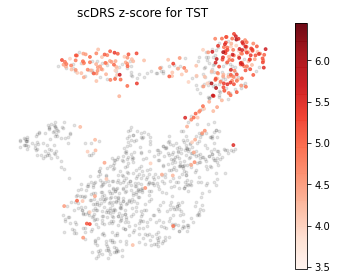

aizarani UKB_460K.biochemistry_Testosterone_Male


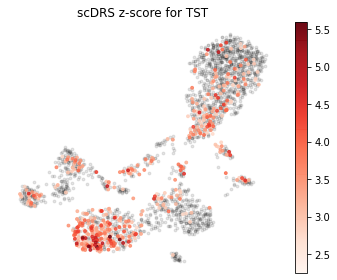

halpern UKB_460K.biochemistry_Testosterone_Male
richter UKB_460K.biochemistry_Testosterone_Male
rao UKB_460K.biochemistry_Testosterone_Male
facs UKB_460K.biochemistry_TotalBilirubin


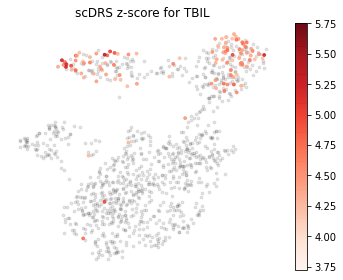

aizarani UKB_460K.biochemistry_TotalBilirubin


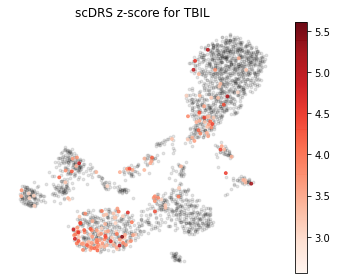

halpern UKB_460K.biochemistry_TotalBilirubin
richter UKB_460K.biochemistry_TotalBilirubin
rao UKB_460K.biochemistry_TotalBilirubin
facs UKB_460K.biochemistry_Triglycerides


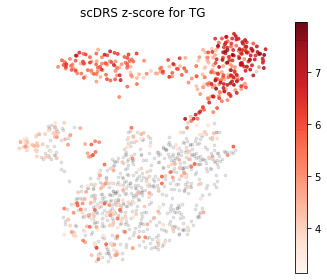

aizarani UKB_460K.biochemistry_Triglycerides


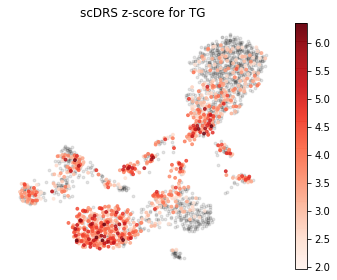

halpern UKB_460K.biochemistry_Triglycerides
richter UKB_460K.biochemistry_Triglycerides
rao UKB_460K.biochemistry_Triglycerides


In [52]:
for trait in DIC_TRAIT_LIST['facs']:
    for ds in DS_LIST:
#     for ds in ['rao']:
        print(ds, trait)
        df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                               data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                     'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                     'leiden_anno':dic_data_proc[ds].obs['leiden']})
        df_plot = df_plot.loc[dic_cell_list[ds]]
        df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
        df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

        ind_select = df_plot['%s.fdr'%trait]<0.1
        if ind_select.sum()<10:
            continue
        
        plt.figure(figsize=[5,4])
        ax = plt.subplot(1,1,1)
        ax.axis('off')
        vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
        vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
        plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                    c='k', s=8, alpha=0.1)
        plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                    c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                    cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
        plt.colorbar()
        plt.title('scDRS z-score for %s'%DF_TRAIT_INFO.loc[trait, 'Code'])

        plt.tight_layout()
        plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
        plt.show()

### Annotation for LDL associated cells 

... storing 'tissue_celltype' as categorical
... storing 'leiden_sig' as categorical


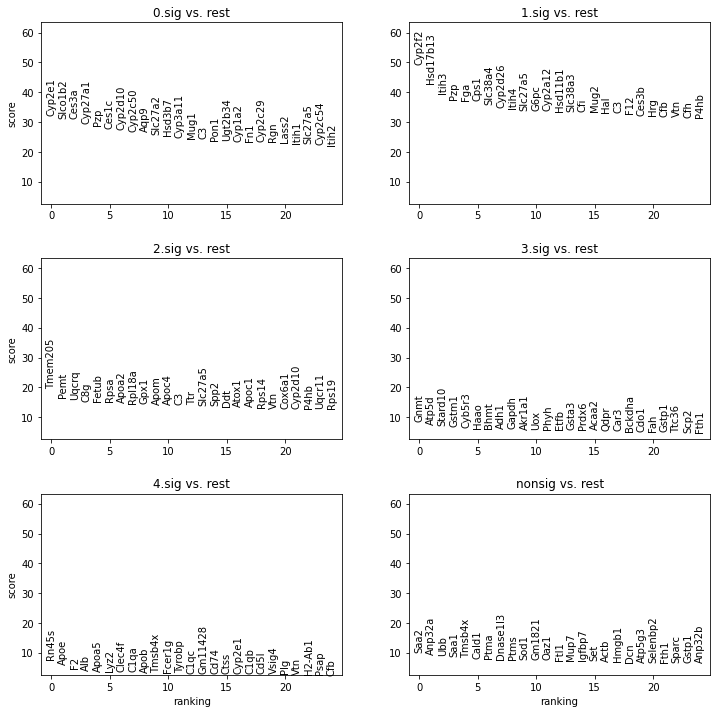

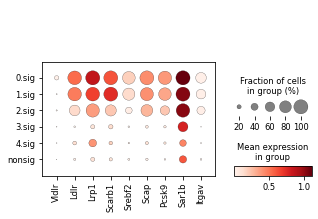

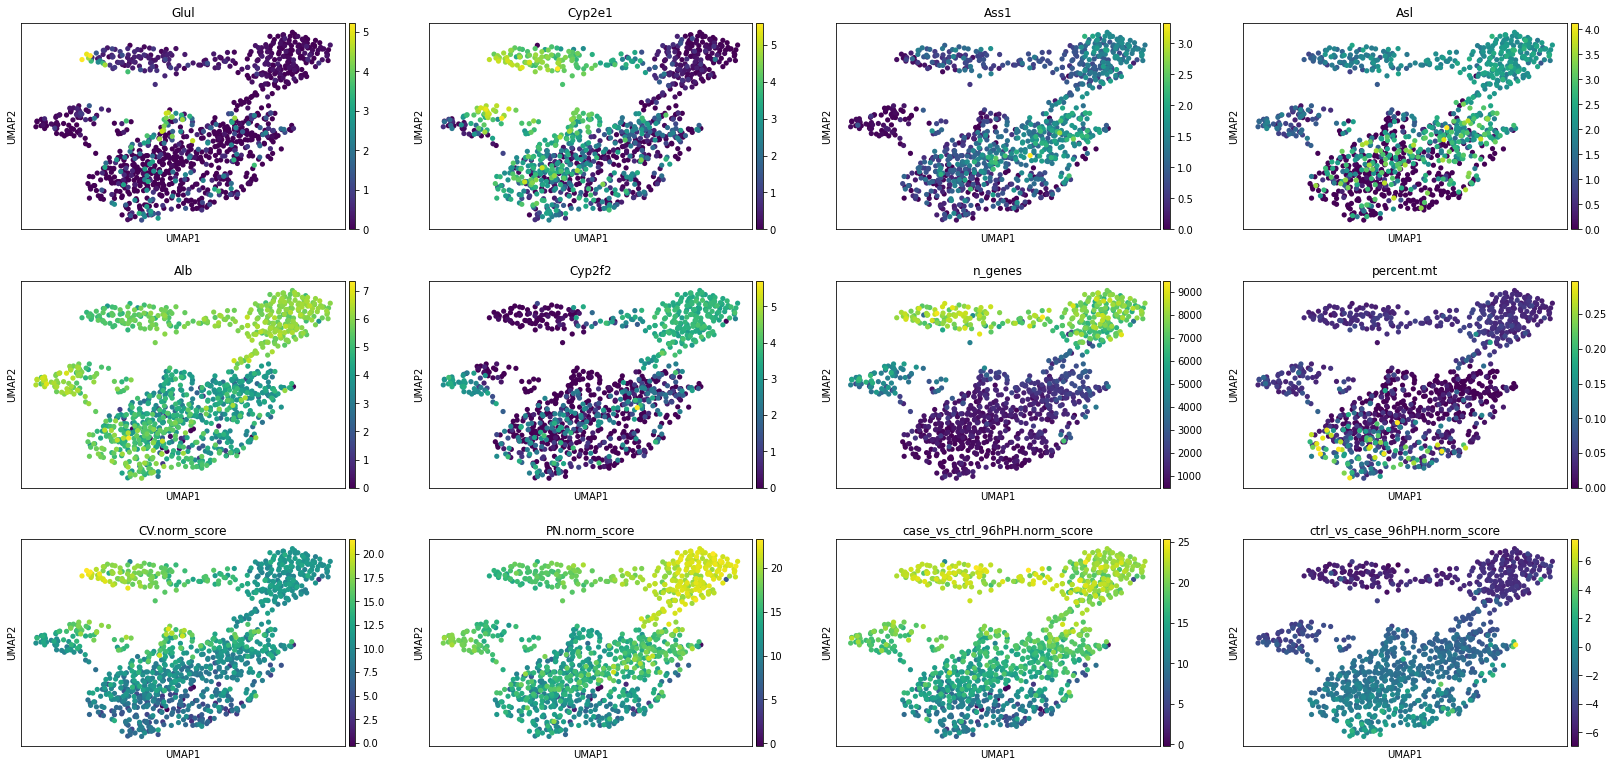

In [8]:
# trait = 'UKB_460K.biochemistry_HDLcholesterol'
# trait = 'UKB_460K.biochemistry_LDLdirect'
trait = 'UKB_460K.biochemistry_Triglycerides'
ds = 'facs'

# Assign sig label for each leiden cluster (remove sig cells in small clusters)
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm

adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['leiden_sig'] = ['%s.sig'%x if y<0.1 else 'nonsig'
                           for x,y in zip(adata.obs['leiden'], adata.obs['%s.fdr'%trait])]

temp_df = adata.obs.groupby(['leiden_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<25])
adata.obs.loc[adata.obs['leiden_sig'].isin(cluster_remove_list), 'leiden_sig'] = 'nonsig' 

# Specifically expressed genes 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
sc.tl.rank_genes_groups(adata, groupby='leiden_sig', reference='rest', groups=group_list+['nonsig'])
sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

# Marker gene expression 
marker_list = ['Vldlr', 'Ldlr', 'Lrp1', 'Scarb1', 'Srebf2', 'Scap', 'Pcsk9', 'Sar1b', 'Itgav', 
#                'Adipoq', 'App', 'Itgb3', 'Psen1', 'Hnrnpk', 'Anxa2', 'Pparg', 'Cnpy2', # Lipoprotein receptor
#                'Alb', # Plasma protein secretion
#                'Fgb', 'F2', 'F9', 'Kng1', 'Aplp2', # Blood clotting factors 
#                'Gc', # Vitamin D
#                'G6pc', # Glycogenolysis and gluconeogenesis
#                'Cyp', 'Glul', 'Oat', 'Ces3a', 'Slc22a1', 'Aldh3a2', # Detoxification
#                'Akr1c6', 'Abcb4', # Bile acid synthesis
#                'Blvrb', # Heme synthesis
#                'Csad', # Amino acid metabolism
#                'Rgn', # Calcium homeostasis
#                'Hmgcl', # Ketogenesis
#                'Stard10', 'Apoa', 'Apoc', # Hormone, vitamin, and lipid transport
#                'Hmgcs2', 'Aldh2', 'Ppara', 'MGll', # Cholesterol, alcohol and lipid metabolism
#                'Agt', 'Igfbp2', 'Igfbp4', # Hormone synthesis and secretion
#                'Hamp', 'Ftl1', 'Hp', # Iron homeostasis and storage
#                'Ass1', 'Asl', # Urea synthesis from ammonia 
#                'Gpx1', # Glutathione synthesis 
#                'Pck1', 'Fbp1', # Gluconeogenesis
#                'Arg1', # Urea synthesis from arginine
#                'Cat', # Catalase production
#                'Cox', 'Nduf' # Respiration (b-oxidation)
#                'Glul', 'Apoe', 'Cyp1a2', 'Cyp2e1', 'Cyp2f2', 'Cyp2e1', # Central
#                'Arg1', 'Alb', 'Pck1' # Periportal
              ]
for gene in marker_list.copy():
    if gene not in adata.var_names:
        marker_list.remove(gene)
        print('# Removed: %s'%gene)
sc.pl.dotplot(adata, marker_list, groupby='leiden_sig')

# Zonation markers
marker_list = ['Glul', 'Cyp2e1', 'Ass1', 'Asl', 'Alb', 'Cyp2f2',
               'n_genes', 'percent.mt', 'CV.norm_score', 'PN.norm_score',
               'case_vs_ctrl_96hPH.norm_score', 'ctrl_vs_case_96hPH.norm_score']
adata.obs = adata.obs.join(dic_score['facs.hm'][['CV.norm_score', 'PN.norm_score',
                                                 'case_vs_ctrl_96hPH.norm_score', 'ctrl_vs_case_96hPH.norm_score']])
sc.pl.umap(adata, color=marker_list)

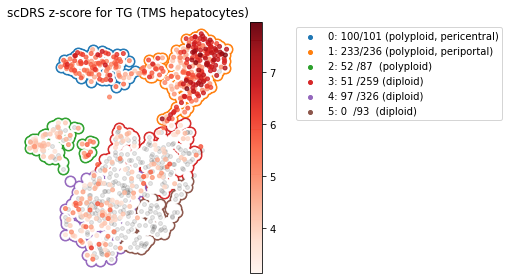

In [10]:
# UMAP plot with annotations 
ds='facs'
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
dic_config = {'0': ['C0', '0: @n (polyploid, pericentral)'],
              '1': ['C1', '1: @n (polyploid, periportal)'],
              '2': ['C2', '2: @n (polyploid)'], 
              '3': ['C3', '3: @n (diploid)'], 
              '4': ['C4', '4: @n (diploid)'],
              '5': ['C5', '5: @n (diploid)']
             }

# Get df_plot 
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['leiden', 'leiden_sig']])
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

# Figure 
plt.figure(figsize=[7,4])
ax = plt.subplot(1,1,1)
ax.axis('off')

# Cluster boundry 
x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
for cluster in dic_config:
    ind_select = df_plot['leiden']==cluster
    n_sig,n_tot = (df_plot['leiden_sig']=='%s.sig'%cluster).sum(),ind_select.sum()
    temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
    xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
    xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
    ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
    ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
    ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                    (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                s=16, color=dic_config[cluster][0], 
                label=dic_config[cluster][1].replace('@n','%-3d/%-3d'%(n_sig,n_tot)), zorder=0)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=120, color=dic_config[cluster][0], zorder=1)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=60, color='w', zorder=2)

ind_select_sig = (df_plot['leiden_sig']!='nonsig')
np.random.seed(0)
cell_list_nonsig = np.random.choice(df_plot.index[~ind_select_sig], 
                                    size=int((~ind_select_sig).sum()*0.5), replace=False)
plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)

vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
            c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
            cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
plt.colorbar()
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
plt.title('scDRS z-score for %s (TMS hepatocytes)'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.tight_layout()
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_%s_umap.svg'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_%s_umap.png'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.show()

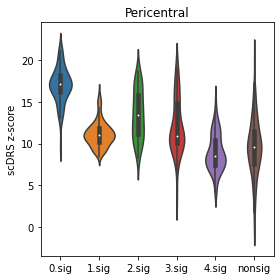

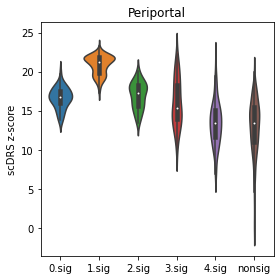

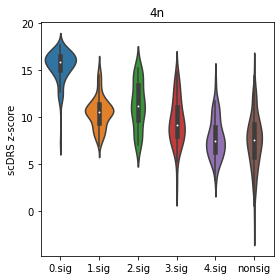

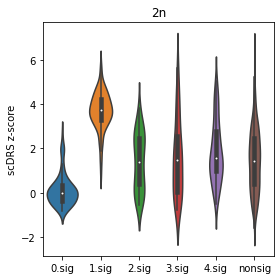

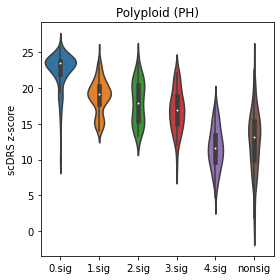

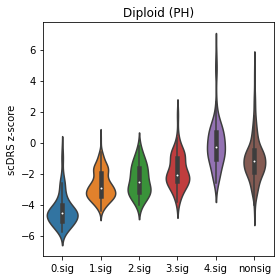

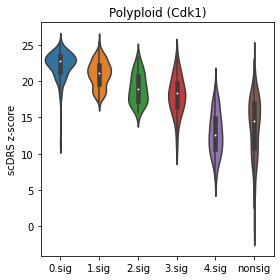

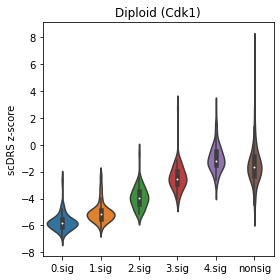

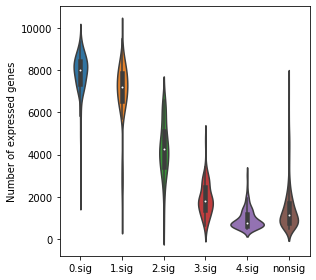

In [16]:
# ploidy score, CV score, PN score
ds = 'facs'
df_plot = adata.obs[['n_genes', 'leiden', 'leiden_sig']]
df_plot = df_plot.join(dic_score['%s.hm'%ds])

for term in ['CV', 'PN', 'hep4n_richter', 'hep2n_richter',  'case_96hPH_vs_prePH', 'case_prePH_vs_96hPH',
             'case_vs_ctrl_96hPH', 'ctrl_vs_case_96hPH']:
    plt.figure(figsize=[4,4])
    sns.violinplot(data=df_plot, x='leiden_sig', y='%s.norm_score'%term)
    plt.xlabel('')
    plt.ylabel('scDRS z-score')
    plt.title(DF_TRAIT_INFO.loc[term,'Code'])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/%s_score.svg'%term)
    plt.show()
    
plt.figure(figsize=[4.5,4])
sns.violinplot(data=df_plot, x='leiden_sig', y='n_genes')
plt.xlabel('')
plt.ylabel('Number of expressed genes')
plt.tight_layout()
plt.savefig(FIG_PATH+'/n_genes.svg')
plt.show()

In [18]:
# # # marker_list = ['Vldlr', 'Ldlr', 'Lrp1', 'Scarb1', 'Srebf2', 'Scap', 'Pcsk9', 'Sar1b', 'Itgav', 
# #                'Adipoq', 'App', 'Itgb3', 'Psen1', 'Hnrnpk', 'Anxa2', 'Pparg', 'Cnpy2'] # Lipoprotein receptor
# marker_list = ['LDLR', 'LRP1', 'SCARB1']
# for ds in DS_LIST:
#     df_plot = None 
#     for gene in marker_list:
#         temp_df =  dic_data_proc[ds].obs[['n_genes']].copy()
#         gene_new = dic_map[gene] if (DIC_INFO[ds]['species']=='mmusculus') else gene
#         temp_df['expr'] = dic_data_raw[ds][dic_data_proc[ds].obs_names, gene_new].X.toarray()
#         temp_df['gene'] = gene
#         temp_df = temp_df.join(dic_score[ds][['%s.fdr'%trait, '%s.norm_score'%trait]])
        
#         temp_df['assoc'] = 0
#         if (temp_df['%s.fdr'%trait]<0.1).mean()>0.05:
#             ind_select = temp_df['%s.fdr'%trait]<0.1
#         else:
#             ind_select = temp_df['%s.norm_score'%trait]>np.quantile(temp_df['%s.norm_score'%trait], 0.9)
#         temp_df.loc[ind_select, 'assoc'] = 1
        
#         if df_plot is None:
#             df_plot = temp_df.copy()
#         else:
#             df_plot = pd.concat([df_plot, temp_df], axis=0)
    
#     plt.figure()
#     sns.violinplot(data=df_plot, x='gene', y='expr', hue='assoc')
# #     sns.boxplot(data=df_plot, x='gene', y='expr', hue='assoc')
# #     sns.stripplot(data=df_plot, x='gene', y='expr', hue='assoc')
#     plt.title(DIC_INFO[ds]['dname'])
#     plt.show()

In [35]:
# # Get gs for pathway analysis 
# dic_gs = {}
# temp_adata = adata.copy()
# sc.tl.rank_genes_groups(temp_adata, groupby='leiden_sig', reference='rest')
# group_list = sorted(adata.obs['leiden_sig'].unique())

# for group in group_list:
#     df_gene = sc.get.rank_genes_groups_df(adata, group=group)
#     dic_gs[group] = list(df_gene['names'][:100])
    
# # Pathway: enrichr
# dic_pathway = {}
# pw_list = []

# for group in dic_gs:
#     res = gp.enrichr(gene_list=dic_gs[group], description='pathway',
#                          gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2018', 'Reactome_2016'],
#                          organism='Mouse', outdir=None)
#     df_pathway = res.results
#     df_pathway = df_pathway.loc[df_pathway['Adjusted P-value']<0.01].copy()
#     df_pathway['Intersect'] = [int(x.split('/')[0]) for x in df_pathway['Overlap']]
#     df_pathway['Term_size'] = [int(x.split('/')[1]) for x in df_pathway['Overlap']]
#     df_pathway['Recall'] = df_pathway['Intersect'] / df_pathway['Term_size']
#     dic_pathway[group] = df_pathway.copy()
#     ind_select = (df_pathway['Term_size']>10) & (df_pathway['Term_size']<500) & (df_pathway['Recall']>0.20) 
#     pw_list.extend(df_pathway.loc[ind_select, 'Term'])\

# for group in dic_gs:
#     dic_pathway[group].index = dic_pathway[group]['Term']
#     dic_pathway[group] = dic_pathway[group].loc[set(dic_pathway[group].index) & set(pw_list)]

In [36]:
# df_plot = pd.DataFrame()
# dic_source = {'KEGG_2019_Mouse':'KEGG', 'GO_Biological_Process_2018':'GO:BP', 'Reactome_2016':'REAC'}
# for group in dic_gs:
#     temp_df = dic_pathway[group][['Adjusted P-value']]
#     temp_df.index = ['%s:%s'%(dic_source[x],y.split(' (GO')[0].split(' Homo')[0]) 
#                      for x,y in zip(dic_pathway[group]['Gene_set'], dic_pathway[group]['Term'])]
#     temp_df.columns = [group]
#     df_plot = df_plot.join(temp_df, how='outer')

# df_plot.fillna(1, inplace=True)
# df_plot = -np.log10(df_plot)
# df_plot = df_plot.loc[df_plot.max(axis=1)>3]
# # df_plot = df_plot[group_list]
# df_plot.index.name = ''
# # df_plot.columns = [x[0] for x in df_plot.columns]

# sns.clustermap(df_plot, metric='cosine', col_cluster=False, 
#                figsize=(15,20), cbar_pos=(0, 0.9, 0.05, 0.05),
#                cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')
# plt.tight_layout()
# # plt.savefig(FIG_PATH+'/IBD_pathway.svg')
# plt.show()

### Joint regression analysis based on covariates 

In [9]:
# Validate ploidy score
for ploidy_term in ['hep4n_richter', 'case_96hPH_vs_prePH', 'case_vs_ctrl_96hPH', 'large_vs_small', 
                    'hep2n_richter', 'case_prePH_vs_96hPH', 'ctrl_vs_case_96hPH']:
    df_reg = dic_data_proc['richter'].obs.copy()
    df_reg['ploidy'] = (df_reg['Ploidy']=='4n')*1
    df_reg = df_reg.join(dic_score['richter.hm'][['%s.norm_score'%ploidy_term]])
    df_reg = df_reg.join(dic_ctrl_score['richter.hm'][ploidy_term])

    corr_ = np.corrcoef(df_reg['ploidy'], df_reg['%s.norm_score'%ploidy_term])[0,1]
    v_corr_ = np.zeros(500) 
    for i in range(500):
        v_corr_[i] = np.corrcoef(df_reg['ploidy'], df_reg['ctrl_norm_score_%d'%i])[0,1]
    if ploidy_term in ['hep4n_richter', 'case_96hPH_vs_prePH', 'case_vs_ctrl_96hPH', 'large_vs_small']:
        p_=((corr_ <= v_corr_).sum()+1) / 501
    else:
        p_=((corr_ >= v_corr_).sum()+1) / 501
    print('# Richter Ploidy and %-20s: Corr.=%0.2f P=%0.3f'%(ploidy_term, corr_, p_))

# Richter Ploidy and hep4n_richter       : Corr.=0.48 P=0.002
# Richter Ploidy and case_96hPH_vs_prePH : Corr.=0.28 P=0.002
# Richter Ploidy and case_vs_ctrl_96hPH  : Corr.=0.20 P=0.002
# Richter Ploidy and large_vs_small      : Corr.=0.25 P=0.002
# Richter Ploidy and hep2n_richter       : Corr.=-0.59 P=0.002
# Richter Ploidy and case_prePH_vs_96hPH : Corr.=-0.20 P=0.002
# Richter Ploidy and ctrl_vs_case_96hPH  : Corr.=-0.15 P=0.002


In [150]:
# Prepare regression datasets 
dic_cov = {}
ploidy_term = 'case_vs_ctrl_96hPH'

# FACS all 
dic_cov['facs'] = dic_data_proc['facs'].obs.copy()
dic_cov['facs']['ploidy'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, '%s.norm_score'%ploidy_term]
dic_cov['facs']['CV'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, 'CV.norm_score']
dic_cov['facs']['PN'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, 'PN.norm_score']

# aizarani
dic_cov['aizarani'] = dic_data_proc['aizarani'].obs.copy()
dic_cov['aizarani']['ploidy'] = dic_score['aizarani.hm'].loc[dic_cov['aizarani'].index, '%s.norm_score'%ploidy_term]
dic_cov['aizarani']['CV'] = dic_score['aizarani.hm'].loc[dic_cov['aizarani'].index, 'CV.norm_score']
dic_cov['aizarani']['PN'] = dic_score['aizarani.hm'].loc[dic_cov['aizarani'].index, 'PN.norm_score']

# halpern
dic_cov['halpern'] = dic_data_proc['halpern'].obs.copy()
dic_cov['halpern']['ploidy'] = dic_score['halpern.hm'].loc[dic_cov['halpern'].index, '%s.norm_score'%ploidy_term]
dic_cov['halpern']['CV'] = dic_score['halpern.hm'].loc[dic_cov['halpern'].index, 'CV.norm_score']
dic_cov['halpern']['PN'] = dic_score['halpern.hm'].loc[dic_cov['halpern'].index, 'PN.norm_score']

# richter
dic_cov['richter'] = dic_data_proc['richter'].obs.copy()
dic_cov['richter']['ploidy'] = dic_score['richter.hm'].loc[dic_cov['richter'].index, '%s.norm_score'%ploidy_term]
dic_cov['richter']['CV'] = dic_score['richter.hm'].loc[dic_cov['richter'].index, 'CV.norm_score']
dic_cov['richter']['PN'] = dic_score['richter.hm'].loc[dic_cov['richter'].index, 'PN.norm_score']

# richter_Ploidy
dic_cov['richter_Ploidy'] = dic_data_proc['richter'].obs.copy()
dic_cov['richter_Ploidy']['ploidy'] = (dic_cov['richter']['Ploidy']=='4n')*1
dic_cov['richter_Ploidy']['CV'] = dic_score['richter.hm'].loc[dic_cov['richter'].index, 'CV.norm_score']
dic_cov['richter_Ploidy']['PN'] = dic_score['richter.hm'].loc[dic_cov['richter'].index, 'PN.norm_score']

# rao
dic_cov['rao'] = dic_data_proc['rao'].obs.copy()
dic_cov['rao']['ploidy'] = dic_score['rao.hm'].loc[dic_cov['rao'].index, '%s.norm_score'%ploidy_term]
dic_cov['rao']['CV'] = dic_score['rao.hm'].loc[dic_cov['rao'].index, 'CV.norm_score']
dic_cov['rao']['PN'] = dic_score['rao.hm'].loc[dic_cov['rao'].index, 'PN.norm_score']

# Regout 
for cov_name in dic_cov:
    mat_Y = np.ones([dic_cov[cov_name].shape[0],2])
    mat_Y[:,1] = dic_cov[cov_name]['ploidy']
    dic_cov[cov_name]['CV'] = md.reg_out(dic_cov[cov_name]['CV'], mat_Y)
    dic_cov[cov_name]['PN'] = md.reg_out(dic_cov[cov_name]['PN'], mat_Y)

In [151]:
# Joint regression analysis
def p_2_str(p_):
    if p_>0.05:
        return ''
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
dic_reg = {'reg_joint': ['ploidy', 'CV', 'PN']}
# dic_reg = {'reg_joint': ['CV', 'PN']}
trait_black_list = ['CV', 'PN']

dic_stats = {}
for cov_name in dic_cov:
    for reg_name in dic_reg:
        print(cov_name, reg_name)
        reg_list = dic_reg[reg_name]
        df_stats = pd.DataFrame(columns=['%s.%s'%(y,x) for x in reg_list for y in ['T', 'P']])
        ds = cov_name.split('_' )[0]
        
        for score in [ds, ds+'.hm']:
            for trait in DIC_TRAIT_LIST[score]:
                if '%s.norm_score'%trait not in dic_score[score]:
                    continue
                if trait in trait_black_list:
                    continue                

                df_reg = dic_cov[cov_name][reg_list].copy()
                df_reg['const'] = 1
                df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
                df_reg = df_reg.join(dic_ctrl_score[score][trait])

                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[['const']+reg_list]).fit()
                dic_t = {x:res.tvalues[x] for x in reg_list}
                dic_t_ctrl = {x:np.zeros(500) for x in reg_list}

                for i in range(500):
                    res = sm.OLS(df_reg['ctrl_norm_score_%d'%i], df_reg[['const']+reg_list]).fit()
                    for reg in reg_list:
                        dic_t_ctrl[reg][i] = res.tvalues[reg]

                dic_p = {x:((dic_t[x] <= dic_t_ctrl[x]).sum()+1) / 501 for x in reg_list} 
#                 dic_p = {x:((np.absolute(dic_t[x]) <= np.absolute(dic_t_ctrl[x])).sum()+1) / 501 for x in reg_list} 
                df_stats.loc[trait] = [y[x] for x in reg_list for y in [dic_t, dic_p]]

        for reg_term in reg_list:
            df_stats['P_STR.%s'%reg_term] = [p_2_str(x) for x in df_stats['P.%s'%reg_term]]
            df_stats['P_STR_NUM.%s'%reg_term] = [p_2_str_num(x) for x in df_stats['P.%s'%reg_term]]
        dic_stats['%s.%s'%(cov_name, reg_name)] = df_stats

facs reg_joint
aizarani reg_joint
halpern reg_joint
richter reg_joint
richter_Ploidy reg_joint
rao reg_joint


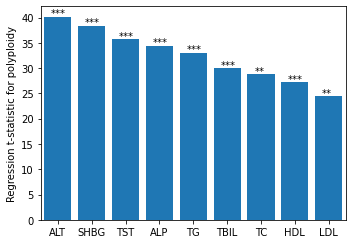

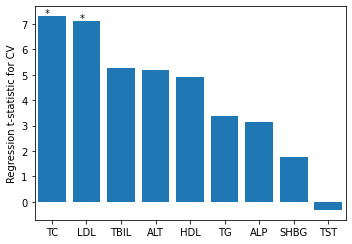

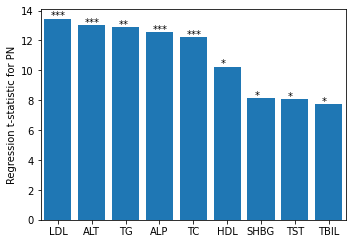

In [152]:
# Polyploidy for FACS 
ds = 'facs'
for cov in ['ploidy', 'CV', 'PN']:
    trait_list_plot = DIC_TRAIT_LIST['facs']
    df_plot = dic_stats['%s.reg_joint'%ds].loc[trait_list_plot].copy()
    df_plot = df_plot.sort_values(ascending=False, by='T.%s'%cov)
    df_plot['loc'] = np.arange(df_plot.shape[0])

    plt.figure(figsize=[5,3.5])
    plt.bar(df_plot['loc'], df_plot['T.%s'%cov])
    for trait in df_plot.index:
        plt.text(df_plot.loc[trait, 'loc']-0.2, df_plot.loc[trait, 'T.%s'%cov], df_plot.loc[trait, 'P_STR.%s'%cov])
    plt.xlim([-0.5, df_plot.shape[0]-0.5])
    plt.xticks(df_plot['loc'], [DF_TRAIT_INFO.loc[x,'Code'] for x in df_plot.index])
    if cov == 'ploidy':
        plt.ylabel('Regression t-statistic for polyploidy')
    else: 
        plt.ylabel('Regression t-statistic for %s'%cov)
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/reg.facs.%s.svg'%cov)
    plt.show()

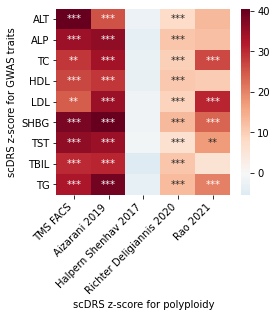

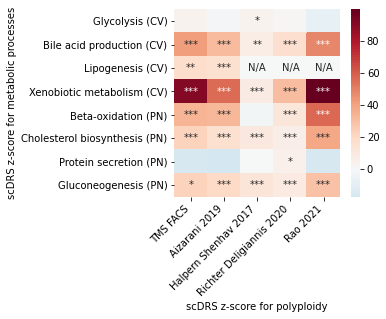

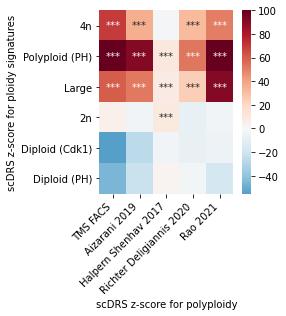

In [153]:
# Ploidy score all data
ds_list = DS_LIST
dic_plot_trait = {'GWAS traits': DIC_TRAIT_LIST['facs'], 
                  'metabolic processes': ['Glycolysis', 'Bile acid production', 'Lipogenesis',
                                           'Xenobiotic metabolism', 'Beta-oxidation', 'Cholesterol biosynthesis', 
                                           'Protein secretion', 'Gluconeogenesis'], 
                  'ploidy signatures': ['hep4n_richter', 'case_96hPH_vs_prePH', 'large_vs_small',
                                        'hep2n_richter', 'ctrl_vs_case_96hPH', 'case_prePH_vs_96hPH', ]}
for trait_name in dic_plot_trait:
    trait_list = dic_plot_trait[trait_name]
    df_plot = pd.DataFrame(index=trait_list, columns=ds_list, dtype=float)
    df_plot_annot = pd.DataFrame(index=trait_list, columns=ds_list)
    for ds in ds_list:
        temp_list = list(set(df_plot[ds].index) & set(dic_stats['%s.reg_joint'%ds].index))
        df_plot.loc[temp_list, ds] = dic_stats['%s.reg_joint'%ds].loc[temp_list, 'T.ploidy']
        df_plot_annot.loc[temp_list, ds] = dic_stats['%s.reg_joint'%ds].loc[temp_list, 'P_STR.ploidy']

    df_plot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x for x in df_plot.index]
    df_plot_annot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x 
                           for x in df_plot_annot.index]
    df_plot.fillna(0, inplace=True)
    df_plot.clip(upper=100, inplace=True)
    df_plot_annot.fillna('N/A', inplace=True)

    plt.figure(figsize=[4+1.5*(trait_name=='metabolic processes'), 4.5])
    sns.heatmap(df_plot, annot=df_plot_annot, fmt='s', cmap='RdBu_r', center=0)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, [DIC_INFO[x]['dname'] for x in df_plot.columns], 
               rotation=45, ha='right')
    plt.yticks(np.arange(df_plot.shape[0])+0.5, df_plot.index)
    plt.xlabel('scDRS z-score for polyploidy')
    plt.ylabel('scDRS z-score for %s'%trait_name)
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sig_ploidy.%s.svg'%trait_name)
    plt.show()
#     break

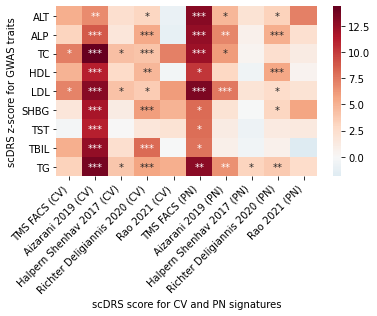

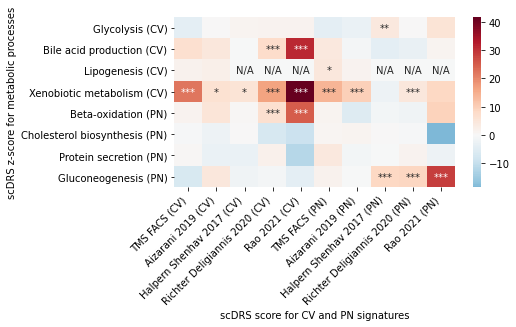

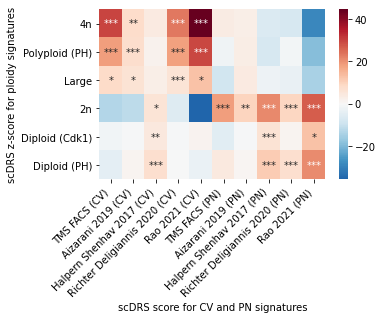

In [154]:
# CV/PN all data
ds_list = DS_LIST

for trait_name in dic_plot_trait:
    trait_list = dic_plot_trait[trait_name]
    col_list = ['%s.%s'%(x,y) for x in ['CV','PN'] for y in ds_list]
    df_plot = pd.DataFrame(index=trait_list, columns=col_list, dtype=float)
    df_plot_annot = pd.DataFrame(index=trait_list, columns=col_list)
    for col in col_list:
        hm,ds = col.split('.')
        temp_list = list(set(df_plot[col].index) & set(dic_stats['%s.reg_joint'%ds].index))
        df_plot.loc[temp_list, col] = dic_stats['%s.reg_joint'%ds].loc[temp_list, 'T.%s'%hm]
        df_plot_annot.loc[temp_list, col] = dic_stats['%s.reg_joint'%ds].loc[temp_list, 'P_STR.%s'%hm]

    df_plot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x for x in df_plot.index]
    df_plot_annot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x 
                           for x in df_plot_annot.index]
    df_plot.fillna(0, inplace=True)
    df_plot_annot.fillna('N/A', inplace=True)
    df_plot.columns 

    plt.figure(figsize=[5.5+2*(trait_name=='metabolic processes'), 4.5])
    sns.heatmap(df_plot, annot=df_plot_annot, fmt='s', cmap='RdBu_r', center=0)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, [DIC_INFO[x.split('.')[1]]['dname'] + ' (%s)'%x.split('.')[0]
                                                 for x in df_plot.columns], 
               rotation=45, ha='right')
    plt.yticks(np.arange(df_plot.shape[0])+0.5, df_plot.index)
    plt.xlabel('scDRS score for CV and PN signatures')
    plt.ylabel('scDRS z-score for %s'%trait_name)  
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sig_cvpn.%s.svg'%trait_name)
    plt.show()
#     break

### Old code 

In [ ]:
# # Correlate polyploidy score with trait signal in facs
# ds = 'facs'
# cov = 'ploidy'

# df_plot = dic_cov[ds].copy()
# df_plot['bin'] = pd.qcut(df_plot[cov], q=5, labels=False)

# # Reorder traits 
# trait_list_plot = DIC_TRAIT_LIST['facs']
# dpt_q80 = np.quantile(df_plot[cov], 0.8)
# cell_list = df_plot.index[df_plot[cov]>dpt_q80]
# temp_df = pd.DataFrame(index=trait_list_plot,
#                        data={'score': [dic_score[ds].loc[cell_list, '%s.norm_score'%x].mean()
#                                        for x in trait_list_plot]})
# temp_df.sort_values(by='score', ascending=False, inplace=True)
# trait_list_plot = list(temp_df.index)

# i_color = 0
# y_text = 8
# plt.figure(figsize=[4.5,4])
# for i_trait,trait in enumerate(trait_list_plot):
    
#     df_plot = df_plot.join(dic_score[ds]['%s.norm_score'%trait])
#     temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
#     temp_df.columns = ['mean']

#     plt.plot(temp_df.index, temp_df['mean'], 'o-', label=DF_TRAIT_INFO.loc[trait, 'Code'], 
#              color='C%d'%i_color)
#     y_text = min(y_text-0.1, temp_df['mean'][4]-0.1)
#     plt.text(4.1, y_text, dic_stats['%s.reg_joint'%ds].loc[trait, 'P_STR.%s'%cov], color='C%d'%i_color)
#     i_color += 1

# plt.xlim([-0.2,4.5])
# plt.ylabel('Mean scDRS score')
# plt.xlabel('Polyploidy quintile bins')
# plt.legend()
# plt.tight_layout()
# #     plt.savefig(FIG_PATH+'/dpt_trait_corr.%s.svg'%term)
# plt.show()

### Prioritize gene sets 

In [52]:
df_gs_gwas = pd.read_csv(GS_FILE, sep='\t', index_col=0)
df_hom = pd.read_csv(DATA_PATH + '/gene_annotation/mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
background_set = set(dic_data_raw['facs'].var_names) & set(dic_map.values())

In [54]:
# Hep specific genes 
temp_adata = dic_data_raw['facs'][:, list(background_set)].copy()
temp_adata.obs['hep'] = 'nh'
temp_adata.obs.loc[dic_data_proc['facs'].obs_names, 'hep'] = 'h'
sc.tl.rank_genes_groups(temp_adata, groupby='hep', groups=['h'])
df_h = sc.get.rank_genes_groups_df(temp_adata, 'h')

... storing 'tissue_celltype' as categorical
... storing 'hep' as categorical


In [87]:
# GWAS and scTRS gene sets 
dic_gs = {}

for trait in DIC_TRAIT_LIST['facs']:
    
    # GWAS gene set
    dic_gs['%s.gwas'%trait] = set([dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map])
    dic_gs['%s.gwas'%trait] = dic_gs['%s.gwas'%trait] & background_set
    
    # scTRS gene set
#     temp_list = dic_data_proc['facs'].obs_names[dic_data_proc['facs'].obs['leiden'].isin(['2'])]
#     temp_adata = dic_data_raw['facs'][temp_list, list(background_set)].copy()
    temp_adata = dic_data_raw['facs'][dic_data_proc['facs'].obs_names, list(background_set)].copy()
    temp_adata.obs['sctrs'] = dic_score['facs'].loc[temp_adata.obs_names, '%s.norm_score'%trait]
    md.correlate_gene(temp_adata, trs_name='sctrs', corr_opt='pearson', cov_list=None)
    df_gene_corr = pd.DataFrame(index=temp_adata.var_names)
    df_gene_corr[trait] = temp_adata.var[['trs_corr']].copy()
    df_gene_corr.sort_values(by=trait, ascending=False, inplace=True)
    dic_gs['%s.sctrs'%trait] = set(df_gene_corr.index[:len(dic_gs['%s.gwas'%trait])])
    
    # tcell-specific genes 
    dic_gs['%s.hep'%trait] = set(df_h['names'][:len(dic_gs['%s.gwas'%trait])])

In [88]:
# Gold standard gene sets 
dic_ref = {'UKB_460K.biochemistry_TotalBilirubin': 'Forgetta_biorxiv_2020:dbilirubin.med',
           'UKB_460K.biochemistry_LDLdirect': 'Forgetta_biorxiv_2020:ldl.med;Forgetta_biorxiv_2020:ldl.drug',
           'UKB_460K.biochemistry_Triglycerides': 'Forgetta_biorxiv_2020:tg.med;Forgetta_biorxiv_2020:tg.drug',
           'UKB_460K.biochemistry_Cholesterol': 'Freund_AJHG_2018:Cardiovascular_Disease',
           'UKB_460K.biochemistry_HDLcholesterol': 'Freund_AJHG_2018:Cardiovascular_Disease'}
for trait in dic_ref: 
     dic_gs['%s.ref'%trait] = set()
        
for gs_ref in ['Freund_AJHG_2018', 'Forgetta_biorxiv_2020']:
    df_gs_gold = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gold_standard_gs/%s.gs'%gs_ref,
                         sep='\t', index_col=0)
#     break
    for trait in dic_ref:
        for trait_ref in dic_ref[trait].split(';'):
            if gs_ref in trait_ref:
                trait_ref = trait_ref.replace('%s:'%gs_ref,'')
                dic_gs['%s.ref'%trait] = dic_gs['%s.ref'%trait] | \
                    set([dic_map[x] for x in df_gs_gold.loc[trait_ref, 'GENESET'].split(',') if x in dic_map])

In [89]:
# Compute stats 
dic_stats = {}
for res in ['gwas', 'sctrs', 'hep']:
    dic_stats[res] = pd.DataFrame(columns=['GWAS', 'GS', 'overlap', 'odds_ratio', 'odds_ratio.ub',
                                           'odds_ratio.lb', 'pval', 'overlap_gene'], dtype=float)
    for trait in dic_ref:
        gs_set = dic_gs['%s.%s'%(trait, res)] & background_set
        ge_set_ref = dic_gs['%s.ref'%trait] & background_set
        pvalue,oddsratio,or_ub,or_lb = util.test_overlap(gs_set, ge_set_ref, background_set)

        dic_stats[res].loc[trait,'GWAS'] = len(gs_set)
        dic_stats[res].loc[trait,'GS'] = len(ge_set_ref)
        dic_stats[res].loc[trait,'overlap'] = len(gs_set & ge_set_ref)
        dic_stats[res].loc[trait,'odds_ratio'] = oddsratio
        dic_stats[res].loc[trait,'odds_ratio.ub'] = or_ub
        dic_stats[res].loc[trait,'odds_ratio.lb'] = or_lb
        dic_stats[res].loc[trait,'pval'] = pvalue
        dic_stats[res].loc[trait,'overlap_gene'] = ','.join(sorted(gs_set & ge_set_ref))

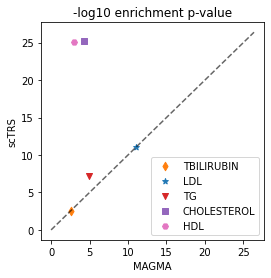

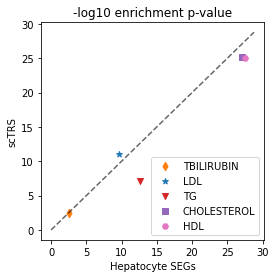

In [92]:
# Scatter plot for comparison 
dic_config = {'gwas': ['C0', 'MAGMA'], 
              'sctrs': ['C1', 'scTRS'], 
              'hep': ['C2', 'Hepatocyte SEGs']}

dic_config_trait = {'UKB_460K.biochemistry_TotalBilirubin': ['C1', 'd'], 
                    'UKB_460K.biochemistry_LDLdirect': ['C0', '*'], 
                    'UKB_460K.biochemistry_Triglycerides': ['C3', 'v'], 
                    'UKB_460K.biochemistry_Cholesterol': ['C4', 's'],
                    'UKB_460K.biochemistry_HDLcholesterol': ['C6', 'H'],
#                     'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED': ['C2', 'D']                   
                    }

df_plot = dic_stats[res][['GS']].copy()
for res in dic_config:
    df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
df_plot = df_plot.astype(dtype=float)
df_plot['loc'] = range(df_plot.shape[0])

for res_ref in ['gwas', 'hep']:
    plt.figure(figsize=[4,4])
    ind_select = (~df_plot.index.isin(dic_config_trait.keys()))
    plt.scatter(df_plot.loc[ind_select, '%s.nlog10pval'%res_ref], df_plot.loc[ind_select, 'sctrs.nlog10pval'],
                color='k', alpha=0.2)
    for trait in dic_config_trait:
        plt.scatter(df_plot.loc[trait, '%s.nlog10pval'%res_ref], df_plot.loc[trait, 'sctrs.nlog10pval'], 
                    color=dic_config_trait[trait][0], marker=dic_config_trait[trait][1], 
                    label=DF_TRAIT_INFO.loc[trait, 'Code'])
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    max_ = max(xmax, ymax)
    plt.plot([0, max_], [0, max_], '--', color='k', alpha=0.6)
    plt.xlabel(dic_config[res_ref][1])
    plt.ylabel(dic_config['sctrs'][1])
    plt.title('-log10 enrichment p-value')
    plt.legend(loc='lower right')
#     plt.tight_layout()
#     plt.savefig(FIG_PATH+'/comparison_gs_%s.svg'%res_ref)
    plt.show()

### Old code

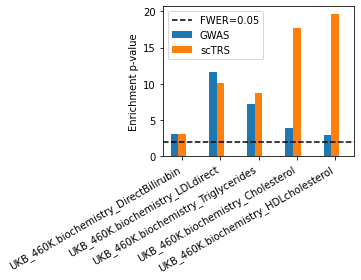

In [109]:
dic_config = {'gwas': ['C0', 'GWAS'], 
              'sctrs': ['C1', 'scTRS']}

df_plot = dic_stats[res][['GS']].copy()
for res in ['gwas', 'sctrs']:
    df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
#     df_plot['%s.or'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio']
#     df_plot['%s.or_lb'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio.lb']
#     df_plot['%s.or_ub'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio.ub']
df_plot = df_plot.astype(dtype=float)
df_plot['loc'] = range(df_plot.shape[0])


plt.figure(figsize=[5, 4])
for i_res,res in enumerate(['gwas', 'sctrs']):
    mat_xerr = np
    plt.bar(df_plot['loc']+0.2*i_res-0.2, df_plot['%s.nlog10pval'%res],
            width=0.2, color=dic_config[res][0], label=dic_config[res][1])

fwer_thres = -np.log10(0.05/df_plot.shape[0])
plt.plot([-0.5, df_plot.shape[0]-0.5], [fwer_thres, fwer_thres], color='k', linestyle='--', 
         label='FWER=0.05')

plt.legend()
plt.xticks(df_plot['loc'], [x for x in df_plot.index], rotation=30, ha='right')
plt.ylabel('Enrichment p-value')
plt.xlim([-0.5, df_plot.shape[0]-0.5])
plt.tight_layout()
plt.savefig(FIG_PATH+'/comparison_gs.svg')
plt.show()

In [ ]:
# Compute p-value
def p_2_str(p_):
    if p_>0.05:
        return 'n.s.'
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
dic_stats = {}
for term in dic_cov:
    df_stats = pd.DataFrame(columns=['COV', 'TRAIT', 'CORR', 'P'])
    ds = term.split('.')[0]
    score = term.split('.')[0]
    
    for cov in ['PN', 'CV']:
        for score in [ds, ds+'.hm']:
            for trait in DIC_TRAIT_LIST[score]:
                if '%s.norm_score'%trait not in dic_score[score]:
                    continue
                    
                df_stats.loc['%s.%s'%(cov,trait), ['COV', 'TRAIT']] = [cov, trait]
                
                df_reg = dic_cov[term][[cov, 'n_genes']].copy()
                df_reg['const'] = 1
                df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
                df_reg = df_reg.join(dic_ctrl_score[score][trait])
                
#                 res = sm.OLS(df_reg[cov], df_reg[['const', 'n_genes', '%s.norm_score'%trait]]).fit()
#                 t_ = res.tvalues['%s.norm_score'%trait]
                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[['const', 'n_genes', cov]]).fit()
                t_ = res.tvalues[cov]
                v_t_ = np.zeros(500)
                for i in range(500):
#                     res = sm.OLS(df_reg[cov],df_reg[['const', 'n_genes', 'ctrl_norm_score_%d'%i]]).fit()
#                     v_t_[i] = res.tvalues['ctrl_norm_score_%d'%i]
                    res = sm.OLS(df_reg['ctrl_norm_score_%d'%i],df_reg[['const', 'n_genes', cov]]).fit()
                    v_t_[i] = res.tvalues[cov]
                p_ = ((t_ <= v_t_).sum()+1) / 501
                df_stats.loc['%s.%s'%(cov,trait), ['CORR', 'P']] = [t_, p_]
            
#                 df_plot = dic_cov[term][[cov]].copy()
#                 df_plot = df_plot.join(dic_score[score][['%s.norm_score'%trait]])
#                 df_plot = df_plot.join(dic_ctrl_score[score][trait])
#         #         corr_ = sp.stats.pearsonr(df_plot[cov].values, df_plot['%s.norm_score'%trait].values)[0]
#                 corr_ = sp.stats.spearmanr(df_plot[cov].values, df_plot['%s.norm_score'%trait].values)[0]
#                 v_corr_ = np.zeros(500)
#                 for i in range(500):
#         #             v_corr_[i] = sp.stats.pearsonr(df_plot[cov].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
#                     v_corr_[i] = sp.stats.spearmanr(df_plot[cov].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
#                 p_ = ((corr_ <= v_corr_).sum()+1) / 501
#                 df_stats.loc['%s.%s'%(cov,trait)] = [cov, trait, corr_, p_]
        
    df_stats['P_STR'] = [p_2_str(x) for x in df_stats['P']]
    df_stats['P_STR_NUM'] = [p_2_str_num(x) for x in df_stats['P']]
    dic_stats[term] = df_stats